In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import Flowers102


In [20]:
dataset_train = Flowers102(root='data/', split="train", download=True)
dataset_val = Flowers102(root='data/', split="val", download=True)
dataset_test = Flowers102(root='data/', split="test", download=True)

print("Train:", len(dataset_train))
print("Val:", len(dataset_val))
print("Test:", len(dataset_test))

Train: 1020
Val: 1020
Test: 6149


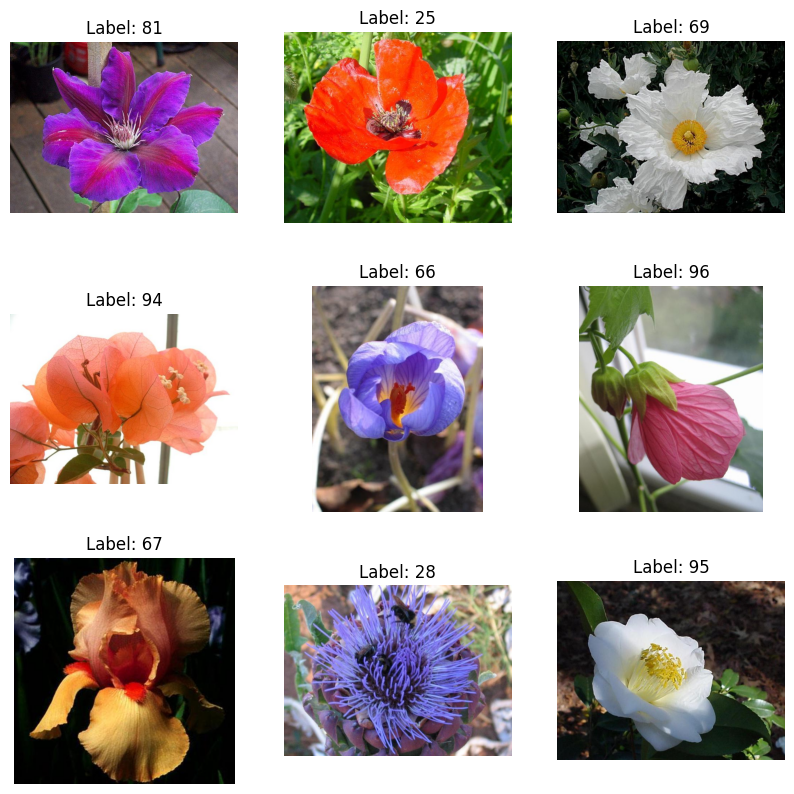

In [21]:
import random
import scipy.io

from matplotlib import pyplot as plt

imagelabels = scipy.io.loadmat("data/flowers-102/imagelabels.mat")

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, (images, targets) in enumerate(random.sample(list(dataset_train), 9)):
    ax = axs[i // 3, i % 3]
    ax.imshow(images)
    ax.set_title(f"Label: {targets}")
    ax.axis('off')
plt.show()


In [22]:
# model = torchvision.models.swin_t(weights='DEFAULT')


In [23]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.BatchNorm2d(8),  
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(238144, 4096),
            nn.BatchNorm1d(4096), 
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.BatchNorm1d(1000), 
            nn.ReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [24]:
img_size = 256
batch_size = 16
lr = 0.001
epochs = 10

val_freq = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# device = torch.device('cpu')

Using device: cuda


In [25]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
])
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack([transform(image) for image in images])
    targets = torch.tensor(targets)
    return images, targets

In [26]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [27]:
import os

save_path = "output/"
os.makedirs(save_path, exist_ok=True)

In [28]:
# TRAIN
from tqdm import tqdm

def train(epochs:int, 
          model:nn.Module, 
          dataloader_train:torch.utils.data.DataLoader, 
          dataloader_val:torch.utils.data.DataLoader, 
          optimizer:torch.optim.Optimizer, 
          criterion:torch.nn.Module, 
          val_freq:int=1):
    
    metrics = {
        "train": {
            "acc": [], 
            "loss": [],
        },
        "val": {        
            "acc": [],
            "loss": [],
        }
    }

    for epoch in range(epochs):
        model.train()
        with tqdm(dataloader_train, unit="batch", total=len(dataloader_train), desc=f"[TRAIN] Epoch {epoch}/{epochs}") as trainbar:
            for i, (images, targets) in enumerate(trainbar):
                images = images.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, targets)

                predicted = torch.argmax(outputs, 1)
                correct = (predicted == targets).sum().item()

                metrics["train"]["acc"].append(correct / batch_size)
                metrics["train"]["loss"].append(loss.item())

                loss.backward()
                optimizer.step()

                trainbar.set_postfix(loss=loss.item())

        if (epoch+1) % val_freq == 0:
            # VALIDATION
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                with tqdm(dataloader_val, unit="batch", total=len(dataloader_val), desc=f"[VAL] Epoch {epoch}/{epochs}") as valbar:
                    for images, targets in valbar:
                        images = images.to(device)
                        targets = targets.to(device)

                        outputs = model(images)
                        loss = criterion(outputs, targets)

                        _, predicted = torch.max(outputs.data, 1)
                        total += targets.size(0)
                        correct += (predicted == targets).sum().item()

                        metrics["val"]["acc"].append(correct / total)
                        metrics["val"]["loss"].append(loss.item())

                        valbar.set_postfix(acc=correct / total)

    return metrics



In [29]:
# TEST
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

def test(model:nn.Module, dataloader_test:torch.utils.data.DataLoader):
    metrics = {
        "correct": 0,
        "total": 0,
        "loss": 0,
    }
    with torch.no_grad():
        with tqdm(dataloader_test, unit="batch", total=len(dataloader_test), desc=f"[TEST]") as testbar:
            for images, targets in testbar:
                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                loss = torch.nn.CrossEntropyLoss()(outputs, targets)
                _, predicted = torch.max(outputs.data, 1)

                metrics["loss"] = loss.item()
                metrics["total"] += targets.size(0)
                metrics["correct"] += (predicted == targets).sum().item()

                testbar.set_postfix(acc=metrics["correct"] / metrics["total"])
    
    torch.save(model.state_dict(), os.path.join(save_path, f"ckpt_{epochs}_{device}.pt"))
    
    return metrics


# Training

### Own CNN

In [30]:
from collections import defaultdict


time_dict = defaultdict(float)

In [31]:
model_own = CNN()
model_own = model_own.to(device)

In [32]:
optimizer = torch.optim.Adam(model_own.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train_metrics_own = train(epochs, model_own, dataloader_train, dataloader_val, optimizer, criterion, val_freq=val_freq)
end.record()
torch.cuda.synchronize()
time_dict["own"] = start.elapsed_time(end)
test_metrics_own = test(model_own, dataloader_test)

[TEST]: 100%|██████████| 385/385 [02:20<00:00,  2.74batch/s, acc=0.224]


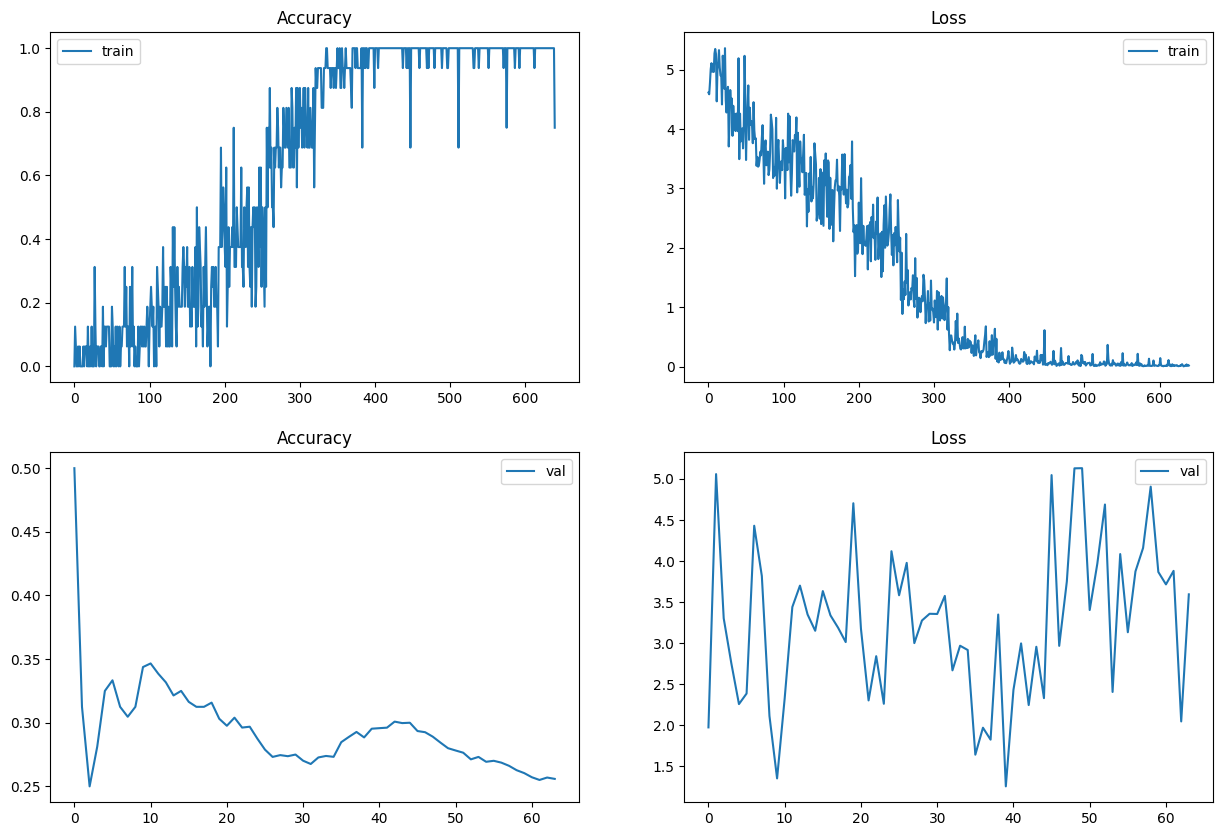

Test accuracy: 22.36
Test loss: 3.34


In [33]:
# PLOT

import numpy as np


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_metrics_own["train"]["acc"], label="train")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(train_metrics_own["train"]["loss"], label="train")
axs[0, 1].set_title("Loss")
axs[0, 1].legend()

axs[1, 0].plot(train_metrics_own["val"]["acc"], label="val")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(train_metrics_own["val"]["loss"], label="val")
axs[1, 1].set_title("Loss")
axs[1, 1].legend()

plt.show()

print(f"Test accuracy: {(test_metrics_own['correct'] / test_metrics_own['total'])*100:.2f}")
print(f"Test loss: {np.mean(test_metrics_own['loss']):.2f}")

### ResNet18

In [34]:
import copy


resnet18_frozen = torchvision.models.resnet18(weights="DEFAULT")
resnet18_finetune = copy.deepcopy(resnet18_frozen)

for name, param in resnet18_frozen.named_parameters():
    if not "fc" in name:
        param.requires_grad = False

resnet18_frozen = resnet18_frozen.to(device)


resnet18_finetune = resnet18_finetune.to(device)



In [35]:
optimizer = torch.optim.Adam(resnet18_frozen.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()




start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train_metrics_res18_fe = train(epochs, resnet18_frozen, dataloader_train, dataloader_val, optimizer, criterion, val_freq=val_freq)
end.record()
torch.cuda.synchronize()
time_dict["resnet18_feature_extractor"] = start.elapsed_time(end)

test_metrics_res18_fe = test(resnet18_frozen, dataloader_test)

[TEST]: 100%|██████████| 385/385 [01:03<00:00,  6.09batch/s, acc=0.681]


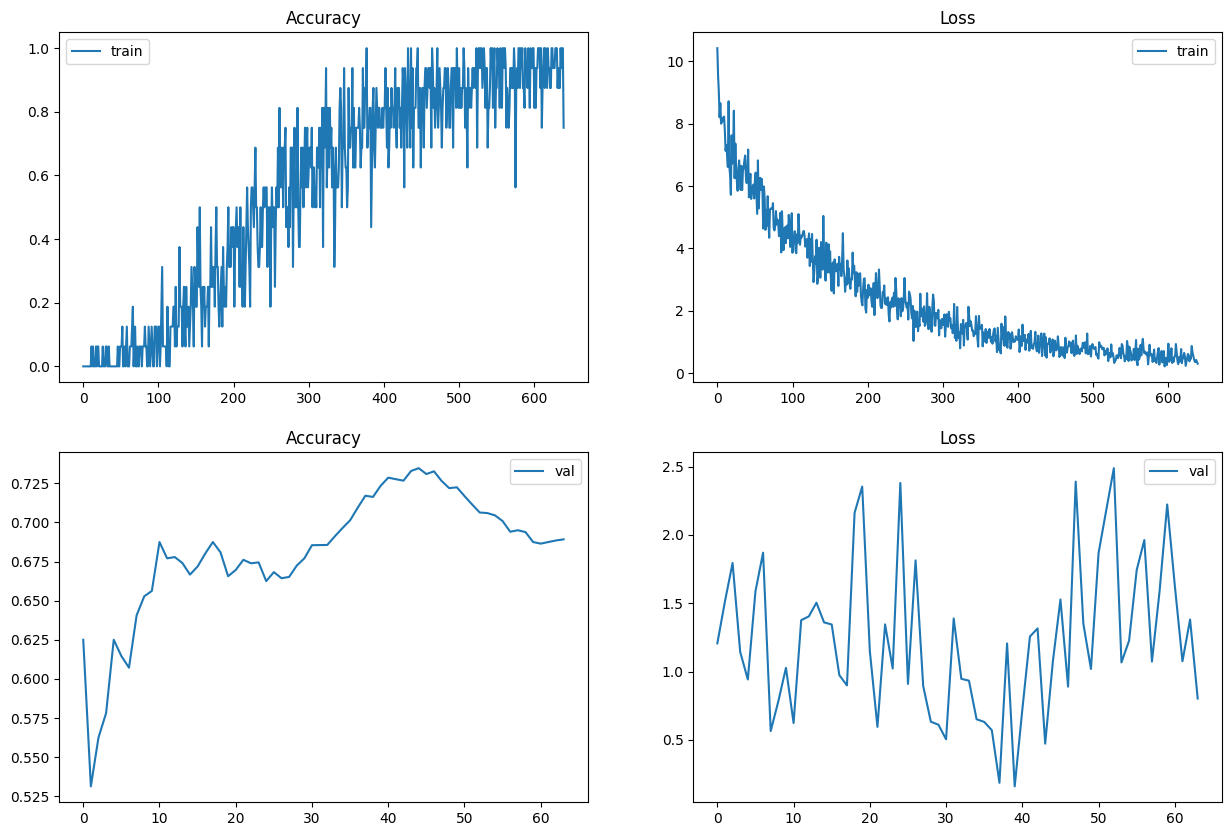

Test accuracy: 68.08
Test loss: 0.87


In [36]:
# PLOT

import numpy as np


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_metrics_res18_fe["train"]["acc"], label="train")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(train_metrics_res18_fe["train"]["loss"], label="train")
axs[0, 1].set_title("Loss")
axs[0, 1].legend()

axs[1, 0].plot(train_metrics_res18_fe["val"]["acc"], label="val")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(train_metrics_res18_fe["val"]["loss"], label="val")
axs[1, 1].set_title("Loss")
axs[1, 1].legend()

plt.show()

print(f"Test accuracy: {(test_metrics_res18_fe['correct'] / test_metrics_res18_fe['total'])*100:.2f}")
print(f"Test loss: {np.mean(test_metrics_res18_fe['loss']):.2f}")

In [37]:
optimizer = torch.optim.Adam(resnet18_finetune.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train_metrics_res18_ft = train(epochs, resnet18_finetune, dataloader_train, dataloader_val, optimizer, criterion, val_freq=val_freq)
end.record()
torch.cuda.synchronize()
time_dict["resnet18_finetuned"] = start.elapsed_time(end)

test_metrics_res18_ft = test(resnet18_finetune, dataloader_test)

[TEST]: 100%|██████████| 385/385 [01:00<00:00,  6.38batch/s, acc=0.488]


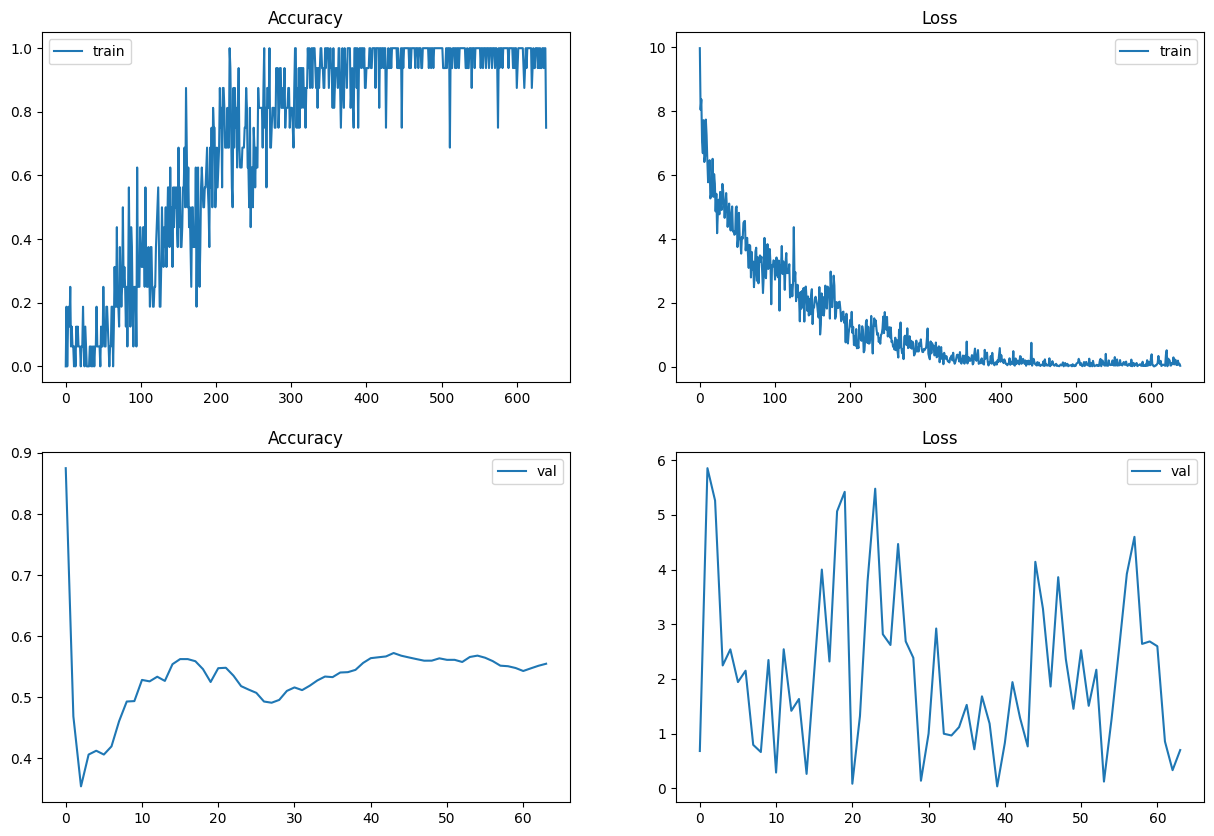

Test accuracy: 48.82
Test loss: 0.88


In [38]:
# PLOT

import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_metrics_res18_ft["train"]["acc"], label="train")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(train_metrics_res18_ft["train"]["loss"], label="train")
axs[0, 1].set_title("Loss")
axs[0, 1].legend()

axs[1, 0].plot(train_metrics_res18_ft["val"]["acc"], label="val")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(train_metrics_res18_ft["val"]["loss"], label="val")
axs[1, 1].set_title("Loss")
axs[1, 1].legend()

plt.show()

print(f"Test accuracy: {(test_metrics_res18_ft['correct'] / test_metrics_res18_ft['total'])*100:.2f}")
print(f"Test loss: {np.mean(test_metrics_res18_ft['loss']):.2f}")

In [39]:
import copy

 
effnet_b5_frozen = torchvision.models.efficientnet_b5(weights="DEFAULT")
effnet_b5_finetune = copy.deepcopy(effnet_b5_frozen)

for name, param in effnet_b5_frozen.named_parameters():
    if not "classifier" in name:
        param.requires_grad = False

effnet_b5_frozen = effnet_b5_frozen.to(device)


effnet_b5_finetune = effnet_b5_finetune.to(device)

In [40]:
optimizer = torch.optim.Adam(effnet_b5_frozen.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()




start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train_metrics_effnetb5_fe = train(epochs, effnet_b5_frozen, dataloader_train, dataloader_val, optimizer, criterion, val_freq=val_freq)
end.record()
torch.cuda.synchronize()
time_dict["effnetb5_feature_extractor"] = start.elapsed_time(end)

test_metrics_effnetb5_fe = test(effnet_b5_frozen, dataloader_test)

[TEST]: 100%|██████████| 385/385 [02:07<00:00,  3.03batch/s, acc=0.604]


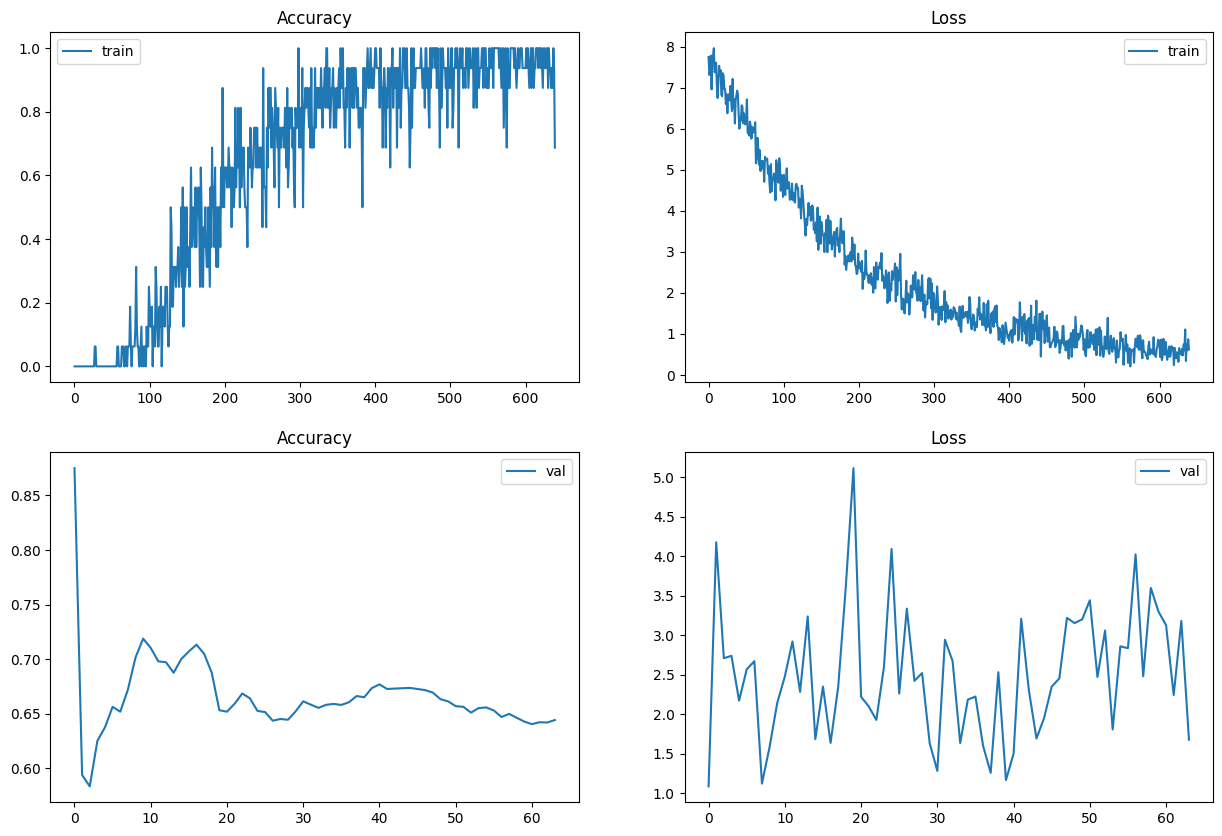

Test accuracy: 60.35
Test loss: 1.15


In [41]:
# PLOT

import numpy as np


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_metrics_effnetb5_fe["train"]["acc"], label="train")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(train_metrics_effnetb5_fe["train"]["loss"], label="train")
axs[0, 1].set_title("Loss")
axs[0, 1].legend()

axs[1, 0].plot(train_metrics_effnetb5_fe["val"]["acc"], label="val")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(train_metrics_effnetb5_fe["val"]["loss"], label="val")
axs[1, 1].set_title("Loss")
axs[1, 1].legend()

plt.show()

print(f"Test accuracy: {(test_metrics_effnetb5_fe['correct'] / test_metrics_effnetb5_fe['total'])*100:.2f}")
print(f"Test loss: {np.mean(test_metrics_effnetb5_fe['loss']):.2f}")

In [42]:
optimizer = torch.optim.Adam(effnet_b5_finetune.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()




start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train_metrics_effnetb5_ft = train(epochs, effnet_b5_finetune, dataloader_train, dataloader_val, optimizer, criterion, val_freq=val_freq)
end.record()
torch.cuda.synchronize()
time_dict["effnetb5_feature_extractor"] = start.elapsed_time(end)

test_metrics_effnetb5_ft = test(effnet_b5_finetune, dataloader_test)

[TRAIN] Epoch 2/10:   3%|▎         | 2/64 [00:30<15:59, 15.48s/batch, loss=0.109]

NameError: name 'time_dict' is not defined

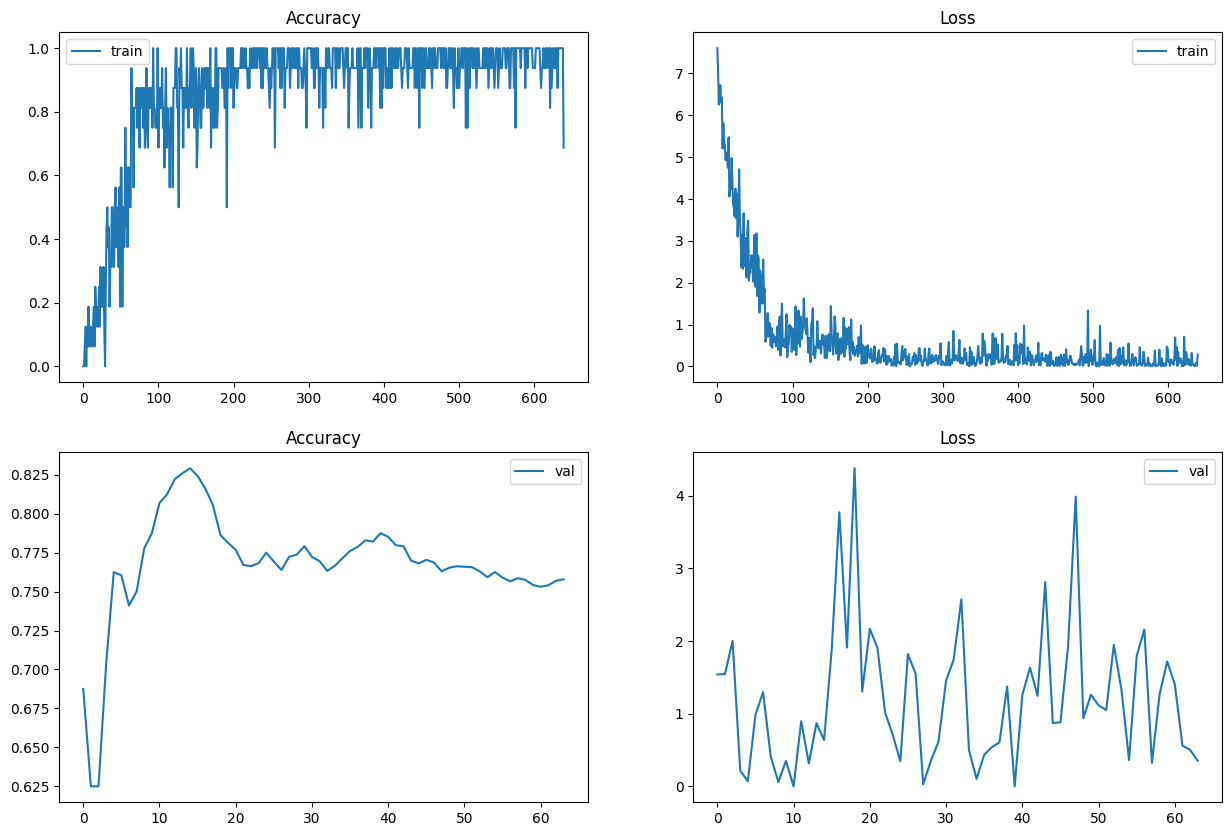

Test accuracy: 72.79
Test loss: 0.02


In [ ]:
# PLOT

import numpy as np


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_metrics_effnetb5_ft["train"]["acc"], label="train")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(train_metrics_effnetb5_ft["train"]["loss"], label="train")
axs[0, 1].set_title("Loss")
axs[0, 1].legend()

axs[1, 0].plot(train_metrics_effnetb5_ft["val"]["acc"], label="val")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(train_metrics_effnetb5_ft["val"]["loss"], label="val")
axs[1, 1].set_title("Loss")
axs[1, 1].legend()

plt.show()

print(f"Test accuracy: {(test_metrics_effnetb5_ft['correct'] / test_metrics_effnetb5_ft['total'])*100:.2f}")
print(f"Test loss: {np.mean(test_metrics_effnetb5_ft['loss']):.2f}")

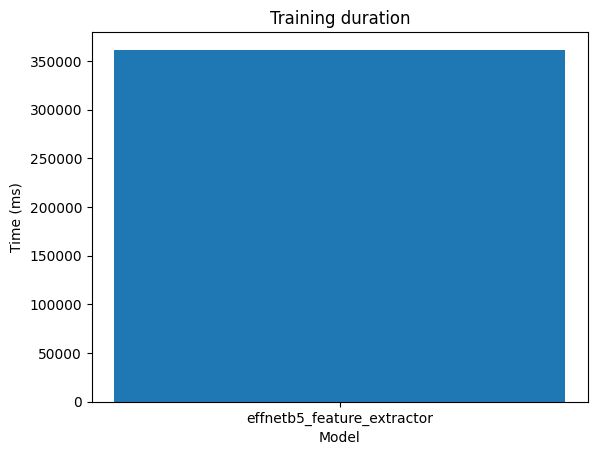

In [ ]:
# PLOT TIME

import matplotlib.pyplot as plt

plt.bar(time_dict.keys(), time_dict.values())
plt.ylabel("Time (ms)")
plt.xlabel("Model")
plt.title("Training duration")
plt.show()

